### Spark Hw2 and Exam: Youtube comments analysis
#### Write a Spark program to analyze the text data.
In this notebook, we have a dataset of user comments for youtube videos related to animals or pets. We will attempt to identify cat or dog owners based on these comments, find out the topics important to them, and then identify video creators with the most viewers that are cat or dog owners.

#### 0. Data Exploration and Cleaning

In [3]:
# read data
df = spark.read.load("/FileStore/tables/animals_comments_csv-5aaff.gz", format='csv', header = True, inferSchema = True)
df.show(10)

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
+--------------------+------+-------------------------------------+
only showing top 10 rows

In [4]:
#remove rows with missing values
to_remove = df['creator_name'].isNull() | df['userid'].isNull() | df['comment'].isNull()
df_clean = df.filter(~to_remove)

In [5]:
# find user with preference of dog and cat
# note: please propose your own approach and rule to label data 

cond = (df_clean["comment"].like("%my dog%") | df_clean["comment"].like("%I have a dog%")\
        | df_clean["comment"].like("%my cat%") | df_clean["comment"].like("%I have a cat%") | df_clean["comment"].like("%dog%")\
       | df_clean["comment"].like("%cat%"))
df_clean = df_clean.withColumn('dog_cat',  cond)

# find user do not have 
df_clean = df_clean.withColumn('no_pet', ~df_clean["comment"].like("%my%") & ~df_clean["comment"].like("%have%") | df_clean["comment"].like("%not allowed%")) 

df_clean.show()

+--------------------+------+-------------------------------------+-------+------+
 creator_name|userid| comment|dog_cat|no_pet|
+--------------------+------+-------------------------------------+-------+------+
 Doug The Pug| 87.0| I shared this to ...| false| false|
 Doug The Pug| 87.0| Super cute 😀🐕🐶| false| true|
 bulletproof| 530.0| stop saying get e...| true| false|
 Meu Zoológico| 670.0| Tenho uma jiboia ...| false| true|
 ojatro|1031.0| I wanna see what ...| false| true|
 Tingle Triggers|1212.0| Well shit now Im ...| false| true|
Hope For Paws - O...|1806.0| when I saw the en...| false| true|
Hope For Paws - O...|2036.0| Holy crap. That i...| false| true|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...| false| true|
 Brian Barczyk|2698.0| Call the teddy Larry| false| true|
 The Dodo|2702.0| 😐🤔😓😢😭😭😭😭😟| false| true|
Hope For Paws - O...|2911.0| That mother cat l...| true| false|
Hope For Paws - O...|2911.0| Its people like H...| false| true|
 Talking Kitty Cat|2911.0| steve: No wet foo...| true| true|
 Brave Wilderness|3224.0| Dont call this a ...| false| true|
 MaxluvsMya|3267.0| why are you alway...| false| true|
Rise Up Society F...|3372.0| Deb Tucker| false| true|
 The Dodo|3466.0| Thats a deer isnt...| false| true|
 Brave Wilderness|3466.0| there is no safe ...| false| true|
 Brave Wilderness|3466.0| Red before yellow...| false| true|
+--------------------+------+-------------------------------------+-------+------+
only showing top 20 rows

In [6]:
from pyspark.sql.functions import when, col
df_clean = df_clean.withColumn('label',(when((col('dog_cat') == 'true') & (col('no_pet') == 'false'),1).otherwise(0)))
df_clean.show()

+--------------------+------+-------------------------------------+-------+------+-----+
 creator_name|userid| comment|dog_cat|no_pet|label|
+--------------------+------+-------------------------------------+-------+------+-----+
 Doug The Pug| 87.0| I shared this to ...| false| false| 0|
 Doug The Pug| 87.0| Super cute 😀🐕🐶| false| true| 0|
 bulletproof| 530.0| stop saying get e...| true| false| 1|
 Meu Zoológico| 670.0| Tenho uma jiboia ...| false| true| 0|
 ojatro|1031.0| I wanna see what ...| false| true| 0|
 Tingle Triggers|1212.0| Well shit now Im ...| false| true| 0|
Hope For Paws - O...|1806.0| when I saw the en...| false| true| 0|
Hope For Paws - O...|2036.0| Holy crap. That i...| false| true| 0|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...| false| true| 0|
 Brian Barczyk|2698.0| Call the teddy Larry| false| true| 0|
 The Dodo|2702.0| 😐🤔😓😢😭😭😭😭😟| false| true| 0|
Hope For Paws - O...|2911.0| That mother cat l...| true| false| 1|
Hope For Paws - O...|2911.0| Its people like H...| false| true| 0|
 Talking Kitty Cat|2911.0| steve: No wet foo...| true| true| 0|
 Brave Wilderness|3224.0| Dont call this a ...| false| true| 0|
 MaxluvsMya|3267.0| why are you alway...| false| true| 0|
Rise Up Society F...|3372.0| Deb Tucker| false| true| 0|
 The Dodo|3466.0| Thats a deer isnt...| false| true| 0|
 Brave Wilderness|3466.0| there is no safe ...| false| true| 0|
 Brave Wilderness|3466.0| Red before yellow...| false| true| 0|
+--------------------+------+-------------------------------------+-------+------+-----+
only showing top 20 rows

#### 1. Build the classifier 
In order to train a model against the comments, you can use RegexTokenizer to split each comment into a list of words and then use Word2Vec or other model to convert the list to a word vector. What Word2Vec does is to map each word to a unique fixed-size vector and then transform each document into a vector using the average of all words in the document.

In [8]:
from pyspark.ml.feature import RegexTokenizer

regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="text", pattern="\\W")
df_clean = regexTokenizer.transform(df_clean)

from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="text", outputCol="cleaned_text")
df_clean = remover.transform(df_clean)

In [9]:
#remove rows with nothing in text
from pyspark.sql.functions import size
df_clean = df_clean.filter(size(col("text")) != 0)

In [10]:
df_clean.show(10)

+--------------------+------+--------------------+-------+------+-----+--------------------+--------------------+
 creator_name|userid| comment|dog_cat|no_pet|label| text| cleaned_text|
+--------------------+------+--------------------+-------+------+-----+--------------------+--------------------+
 Doug The Pug| 87.0|I shared this to ...| false| false| 0|[i, shared, this,...|[shared, friends,...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶| false| true| 0| [super, cute]| [super, cute]|
 bulletproof| 530.0|stop saying get e...| true| false| 1|[stop, saying, ge...|[stop, saying, ge...|
 Meu Zoológico| 670.0|Tenho uma jiboia ...| false| true| 0|[tenho, uma, jibo...|[tenho, uma, jibo...|
 ojatro|1031.0|I wanna see what ...| false| true| 0|[i, wanna, see, w...|[wanna, see, happ...|
 Tingle Triggers|1212.0|Well shit now Im ...| false| true| 0|[well, shit, now,...|[well, shit, im, ...|
Hope For Paws - O...|1806.0|when I saw the en...| false| true| 0|[when, i, saw, th...|[saw, end, said, ...|
Hope For Paws - O...|2036.0|Holy crap. That i...| false| true| 0|[holy, crap, that...|[holy, crap, quit...|
 Brian Barczyk|2698.0|Call the teddy Larry| false| true| 0|[call, the, teddy...|[call, teddy, larry]|
Hope For Paws - O...|2911.0|That mother cat l...| true| false| 1|[that, mother, ca...|[mother, cat, loo...|
+--------------------+------+--------------------+-------+------+-----+--------------------+--------------------+
only showing top 10 rows

In [11]:
df_sample = df_clean.select("creator_name", "userid", "label", "cleaned_text").sampleBy("label",fractions = {1:1,0:0.012},seed=123)

In [12]:
df_sample.show(10)

+--------------------+-------+-----+--------------------+
 creator_name| userid|label| cleaned_text|
+--------------------+-------+-----+--------------------+
 bulletproof| 530.0| 1|[stop, saying, ge...|
Hope For Paws - O...| 2911.0| 1|[mother, cat, loo...|
 Nathan Coffee| 9431.0| 0| [cute]|
 Viktor Larkhill|10269.0| 1|[hey, victor, won...|
 Taylor Nicole Dean|10336.0| 1|[dont, understand...|
Zak Georges Dog T...|10765.0| 1|[chestnut, cute, ...|
 Maddie Smith|13796.0| 1|[training, pets, ...|
Gone to the Snow ...|13796.0| 1|[man, dogs, worst...|
 The Dodo|24401.0| 0| [nice, video]|
 The Dodo|24401.0| 1| [want, try, dog]|
+--------------------+-------+-----+--------------------+
only showing top 10 rows

In [13]:
df_sample.count()

Out[ 10 ]: 206440

In [14]:
from pyspark.ml.feature import Word2Vec
word2Vec = Word2Vec(vectorSize=10,seed=123,inputCol="cleaned_text", outputCol="features")
model = word2Vec.fit(df_sample)
result = model.transform(df_sample)

In [15]:
result.show()

+--------------------+-------+-----+--------------------+--------------------+
 creator_name| userid|label| cleaned_text| features|
+--------------------+-------+-----+--------------------+--------------------+
 bulletproof| 530.0| 1|[stop, saying, ge...|[-0.1292912968744...|
Hope For Paws - O...| 2911.0| 1|[mother, cat, loo...|[0.35270279473983...|
 Nathan Coffee| 9431.0| 0| [cute]|[0.95945453643798...|
 Viktor Larkhill|10269.0| 1|[hey, victor, won...|[0.17772118453867...|
 Taylor Nicole Dean|10336.0| 1|[dont, understand...|[-0.2070025822650...|
Zak Georges Dog T...|10765.0| 1|[chestnut, cute, ...|[0.02614831080427...|
 Maddie Smith|13796.0| 1|[training, pets, ...|[-0.0034727414604...|
Gone to the Snow ...|13796.0| 1|[man, dogs, worst...|[0.22369944714009...|
 The Dodo|24401.0| 0| [nice, video]|[0.34080044180154...|
 The Dodo|24401.0| 1| [want, try, dog]|[-0.1773353392879...|
 stacyvlogs|24646.0| 1|[male, cats, lot,...|[0.03094573758010...|
 Viktor Larkhill|33849.0| 1|[love, suki, alth...|[0.06922848799609...|
 Taylor Nicole Dean|35609.0| 0|[feel, thing, rat...|[0.00527502693743...|
 Brian Barczyk|36364.0| 1|[ive, surrounded,...|[-0.0361729099438...|
Gone to the Snow ...|37636.0| 1|[askgttsd, 8, mon...|[-0.1327637263080...|
 Cole & Marmalade|43112.0| 1|[blow, smoke, cat...|[-0.1021540711323...|
 Funny Pets|43424.0| 0|[0, 35, try, smil...|[0.08896161150187...|
 Cole & Marmalade|56494.0| 0| [poor, cats]|[0.28114189952611...|
Zak Georges Dog T...|63541.0| 1|[dog, lucky, wont...|[-0.1261070209244...|
Zak Georges Dog T...|63541.0| 1|[hey, zak, ive, g...|[-0.0741890885774...|
+--------------------+-------+-----+--------------------+--------------------+
only showing top 20 rows

In [16]:
test = result.sampleBy("label",fractions = {1:0.2,0:0.2},seed=1234)
train = result.subtract(test)

In [17]:
test.cache()
train.cache()

Out[ 10 ]: DataFrame[creator_name: string, userid: double, label: int, cleaned_text: array<string>, features: vector]

In [18]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "label",featuresCol = "features")
model = lr.fit(train)


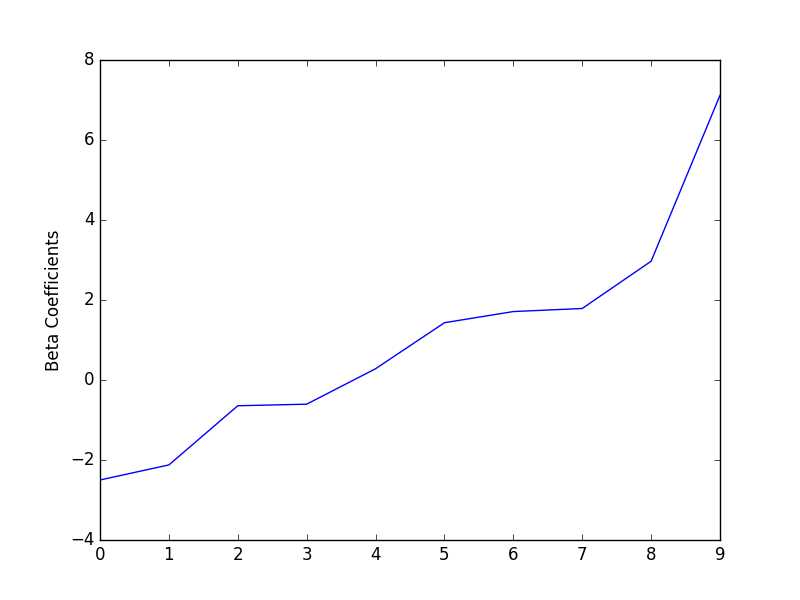

In [19]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
display(plt.show())

In [20]:
plt.gcf().clear()

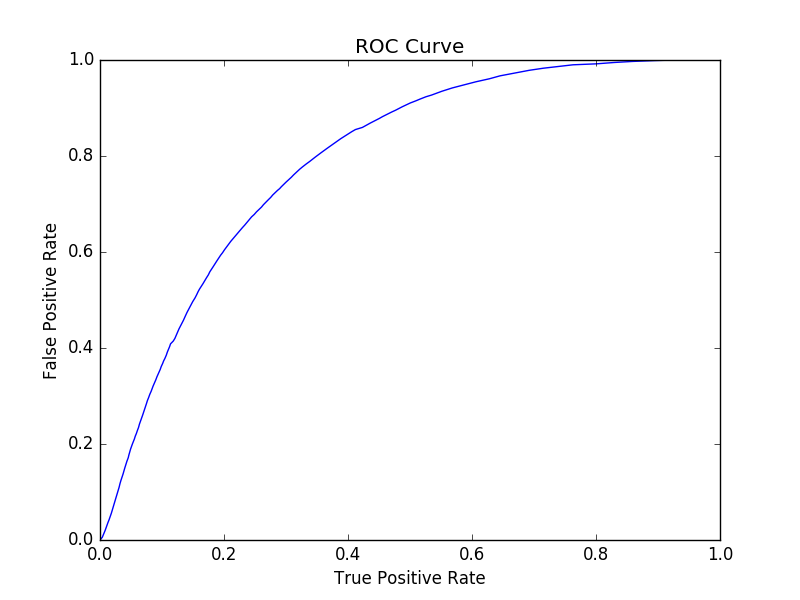

In [21]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
display(plt.show())


In [22]:
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Training set areaUnderROC: 0.7916560474072207

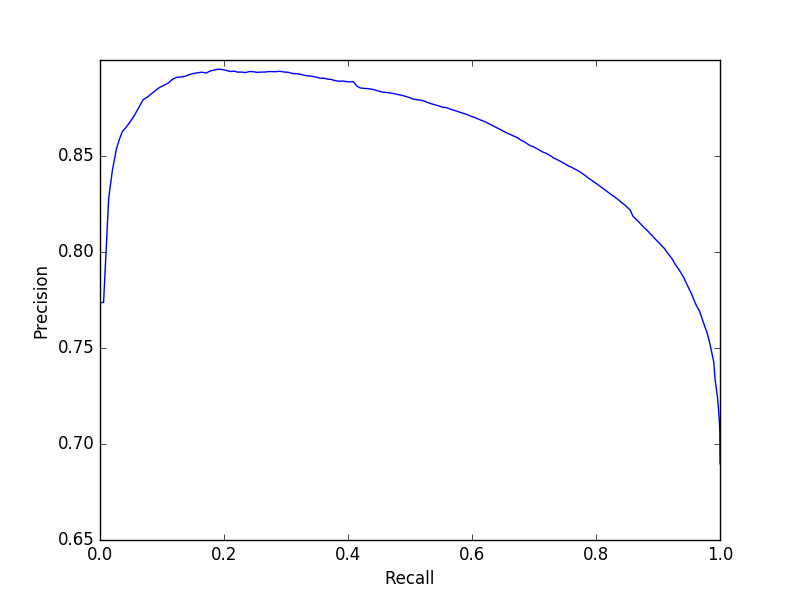

In [23]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
display(plt.show())

In [24]:
predictions = model.transform(test)
predictions.show(10)

+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 creator_name| userid|label| cleaned_text| features| rawPrediction| probability|prediction|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 Maddie Smith|13796.0| 1|[training, pets, ...|[-0.0034727414604...|[-1.8707105389201...|[0.13345952866606...| 1.0|
 Viktor Larkhill|33849.0| 1|[love, suki, alth...|[0.06922848799609...|[-1.6098089351986...|[0.16661514210000...| 1.0|
Gone to the Snow ...|37636.0| 1|[askgttsd, 8, mon...|[-0.1327637263080...|[-2.4487394265106...|[0.07953078136996...| 1.0|
 Cole & Marmalade|43112.0| 1|[blow, smoke, cat...|[-0.1021540711323...|[-1.2312538236020...|[0.22596205261923...| 1.0|
Zak Georges Dog T...|63541.0| 1|[dog, lucky, wont...|[-0.1261070209244...|[-2.4925586787992...|[0.07638149354796...| 1.0|
Zak Georges Dog T...|63541.0| 1|[hey, zak, ive, g...|[-0.0741890885774...|[-2.3160448087433...|[0.08980282577735...| 1.0|
 The Pet Collective|74976.0| 1|[great, cat, vide...|[0.40066960081458...|[0.02132869596993...|[0.50533197186195...| 0.0|
 Viktor Larkhill|89939.0| 1|[oh, god, whoever...|[0.22991701389622...|[-0.0734687425537...|[0.48164107155066...| 1.0|
 The Dodo|89939.0| 0| [lovely]|[0.76607465744018...|[-1.7520538052207...|[0.14778834037481...| 1.0|
 New York Bully Crew|89939.0| 1|[thanks, blessing...|[0.16092751003228...|[-1.0620333046833...|[0.25692107931363...| 1.0|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 10 rows

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7948929423798767

In [26]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show(10)

+--------------------+-------+-----+--------------------+--------------------+-----------------+--------------------+----------+
 creator_name| userid|label| cleaned_text| features| rawPrediction| probability|prediction|
+--------------------+-------+-----+--------------------+--------------------+-----------------+--------------------+----------+
 Maddie Smith|13796.0| 1|[training, pets, ...|[-0.0034727414604...|[24874.0,98804.0]|[0.20111903491324...| 1.0|
 Viktor Larkhill|33849.0| 1|[love, suki, alth...|[0.06922848799609...|[24874.0,98804.0]|[0.20111903491324...| 1.0|
Gone to the Snow ...|37636.0| 1|[askgttsd, 8, mon...|[-0.1327637263080...|[24874.0,98804.0]|[0.20111903491324...| 1.0|
 Cole & Marmalade|43112.0| 1|[blow, smoke, cat...|[-0.1021540711323...|[24874.0,98804.0]|[0.20111903491324...| 1.0|
Zak Georges Dog T...|63541.0| 1|[dog, lucky, wont...|[-0.1261070209244...|[24874.0,98804.0]|[0.20111903491324...| 1.0|
Zak Georges Dog T...|63541.0| 1|[hey, zak, ive, g...|[-0.0741890885774...|[24874.0,98804.0]|[0.20111903491324...| 1.0|
 The Pet Collective|74976.0| 1|[great, cat, vide...|[0.40066960081458...| [2541.0,3720.0]|[0.40584571154767...| 1.0|
 Viktor Larkhill|89939.0| 1|[oh, god, whoever...|[0.22991701389622...| [20659.0,9497.0]|[0.68507096431887...| 0.0|
 The Dodo|89939.0| 0| [lovely]|[0.76607465744018...|[24874.0,98804.0]|[0.20111903491324...| 1.0|
 New York Bully Crew|89939.0| 1|[thanks, blessing...|[0.16092751003228...|[24874.0,98804.0]|[0.20111903491324...| 1.0|
+--------------------+-------+-----+--------------------+--------------------+-----------------+--------------------+----------+
only showing top 10 rows

In [27]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6873325137289121

In [28]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.show(10)

+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 creator_name| userid|label| cleaned_text| features| rawPrediction| probability|prediction|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 Maddie Smith|13796.0| 1|[training, pets, ...|[-0.0034727414604...|[3.20896794203245...|[0.16044839710162...| 1.0|
 Viktor Larkhill|33849.0| 1|[love, suki, alth...|[0.06922848799609...|[3.20896794203245...|[0.16044839710162...| 1.0|
Gone to the Snow ...|37636.0| 1|[askgttsd, 8, mon...|[-0.1327637263080...|[3.20896794203245...|[0.16044839710162...| 1.0|
 Cole & Marmalade|43112.0| 1|[blow, smoke, cat...|[-0.1021540711323...|[3.82972539788494...|[0.19148626989424...| 1.0|
Zak Georges Dog T...|63541.0| 1|[dog, lucky, wont...|[-0.1261070209244...|[5.14773248902667...|[0.25738662445133...| 1.0|
Zak Georges Dog T...|63541.0| 1|[hey, zak, ive, g...|[-0.0741890885774...|[3.54081002659039...|[0.17704050132951...| 1.0|
 The Pet Collective|74976.0| 1|[great, cat, vide...|[0.40066960081458...|[13.7852844671648...|[0.68926422335824...| 0.0|
 Viktor Larkhill|89939.0| 1|[oh, god, whoever...|[0.22991701389622...|[11.0356634763079...|[0.55178317381539...| 0.0|
 The Dodo|89939.0| 0| [lovely]|[0.76607465744018...|[11.8077483240772...|[0.59038741620386...| 0.0|
 New York Bully Crew|89939.0| 1|[thanks, blessing...|[0.16092751003228...|[7.11363136098697...|[0.35568156804934...| 1.0|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 10 rows

In [29]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8095338388802179

In [30]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier()
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.show(10)

+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 creator_name| userid|label| cleaned_text| features| rawPrediction| probability|prediction|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 Maddie Smith|13796.0| 1|[training, pets, ...|[-0.0034727414604...|[-1.1325658897733...|[0.09405219673285...| 1.0|
 Viktor Larkhill|33849.0| 1|[love, suki, alth...|[0.06922848799609...|[-1.0307338790839...|[0.11289874670438...| 1.0|
Gone to the Snow ...|37636.0| 1|[askgttsd, 8, mon...|[-0.1327637263080...|[-1.1369581837119...|[0.09330635830993...| 1.0|
 Cole & Marmalade|43112.0| 1|[blow, smoke, cat...|[-0.1021540711323...|[-0.3365561263264...|[0.33780030602893...| 1.0|
Zak Georges Dog T...|63541.0| 1|[dog, lucky, wont...|[-0.1261070209244...|[-0.3260618154731...|[0.34251114163844...| 1.0|
Zak Georges Dog T...|63541.0| 1|[hey, zak, ive, g...|[-0.0741890885774...|[-1.1308211070588...|[0.09434995146607...| 1.0|
 The Pet Collective|74976.0| 1|[great, cat, vide...|[0.40066960081458...|[0.86266479031006...|[0.84881404702589...| 0.0|
 Viktor Larkhill|89939.0| 1|[oh, god, whoever...|[0.22991701389622...|[0.41753237869042...|[0.69742477989691...| 0.0|
 The Dodo|89939.0| 0| [lovely]|[0.76607465744018...|[0.90933744060268...|[0.86040704730989...| 0.0|
 New York Bully Crew|89939.0| 1|[thanks, blessing...|[0.16092751003228...|[-0.0708330918677...|[0.46464256756185...| 1.0|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 10 rows

In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8501594470790586

In [32]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=20,maxBins=40,maxDepth=6)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.show(10)

+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 creator_name| userid|label| cleaned_text| features| rawPrediction| probability|prediction|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
 Maddie Smith|13796.0| 1|[training, pets, ...|[-0.0034727414604...|[-1.0806698308155...|[0.10327631900984...| 1.0|
 Viktor Larkhill|33849.0| 1|[love, suki, alth...|[0.06922848799609...|[-0.8569480526039...|[0.15265905561995...| 1.0|
Gone to the Snow ...|37636.0| 1|[askgttsd, 8, mon...|[-0.1327637263080...|[-1.1735357265025...|[0.08729883061621...| 1.0|
 Cole & Marmalade|43112.0| 1|[blow, smoke, cat...|[-0.1021540711323...|[-0.5754822789484...|[0.24031294671469...| 1.0|
Zak Georges Dog T...|63541.0| 1|[dog, lucky, wont...|[-0.1261070209244...|[-0.6409881934326...|[0.21721398661425...| 1.0|
Zak Georges Dog T...|63541.0| 1|[hey, zak, ive, g...|[-0.0741890885774...|[-1.1681900170751...|[0.08815446598096...| 1.0|
 The Pet Collective|74976.0| 1|[great, cat, vide...|[0.40066960081458...|[0.73776203338880...|[0.81389556532862...| 0.0|
 Viktor Larkhill|89939.0| 1|[oh, god, whoever...|[0.22991701389622...|[0.85204136769011...|[0.84606721170150...| 0.0|
 The Dodo|89939.0| 0| [lovely]|[0.76607465744018...|[1.67085340833097...|[0.96583221266006...| 0.0|
 New York Bully Crew|89939.0| 1|[thanks, blessing...|[0.16092751003228...|[-0.2882039282707...|[0.35975956399285...| 1.0|
+--------------------+-------+-----+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 10 rows

In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8551537890881384

#### Gradient-Boosted Tree achieved the best results, we will try tuning this model with the ParamGridBuilder and the CrossValidator.

In [35]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (default: all)
featuresCol: features column name. (default: features)
labelCol: label column name. (default: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features. Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 5)
maxIter: max number of iterations (>= 0). (default: 20, current: 10)
maxMemoryInMB: Maximum memory in MB allocated to histogram aggregation. If too small, then 1 node will be split per iteration, and its aggregates may exceed this size. (default: 256)
minInfoGain: Minimum information gain for a split to be considered at a tree node. (default: 0.0)
minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1)
predictionCol: prediction column name. (default: prediction)
seed: random seed. (default: 5897700075777799145)
stepSize: Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator. (default: 0.1)
subsamplingRate: Fraction of the training data used for learning each decision tree, in range (0, 1]. (default: 1.0)

In [36]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4])
             .addGrid(gbt.maxBins, [20, 32])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

In [37]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA
import pyspark.sql.functions as f

test_cat_dog_df = predictions.filter(f.col('prediction')=='1.0').select('cleaned_text')

#TF model
count_vec = CountVectorizer(inputCol = 'cleaned_text',outputCol = 'rawFeatures',vocabSize = 123241, minDF = 2.0)
count_vec_model = count_vec.fit(test_cat_dog_df)
featurizedData = count_vec_model.transform(test_cat_dog_df)
vocab = count_vec_model.vocabulary

#IDF model
idf = IDF(inputCol = 'rawFeatures',outputCol = 'features',minDocFreq=2)
idfmodel = idf.fit(featurizedData)
rescaledData = idfmodel.transform(featurizedData)
rescaledData.cache()




Out[ 77 ]: DataFrame[cleaned_text: array<string>, rawFeatures: vector, features: vector]

In [38]:
rescaledData.show(10)

+--------------------+--------------------+--------------------+
 cleaned_text| rawFeatures| features|
+--------------------+--------------------+--------------------+
[training, pets, ...|(18001,[2,3,6,17,...|(18001,[2,3,6,17,...|
[love, suki, alth...|(18001,[1,2,4,20,...|(18001,[1,2,4,20,...|
[askgttsd, 8, mon...|(18001,[3,9,11,23...|(18001,[3,9,11,23...|
[blow, smoke, cat...|(18001,[6,90,822,...|(18001,[6,90,822,...|
[dog, lucky, wont...|(18001,[0,7,144,2...|(18001,[0,7,144,2...|
[hey, zak, ive, g...|(18001,[0,3,20,39...|(18001,[0,3,20,39...|
[thanks, blessing...|(18001,[4,5,59,61...|(18001,[4,5,59,61...|
[re, dogs, beauti...|(18001,[3,11,13,7...|(18001,[3,11,13,7...|
[smart, like, tri...|(18001,[1,556,481...|(18001,[1,556,481...|
[6, month, old, b...|(18001,[0,1,3,6,1...|(18001,[0,1,3,6,1...|
+--------------------+--------------------+--------------------+
only showing top 10 rows

In [39]:
#LDA
lda = LDA(k=10, maxIter=10)
lda_model = lda.fit(rescaledData.select('features'))
topics = lda_model.describeTopics(10)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)
# Shows the result
transformed = lda_model.transform(rescaledData)
transformed.show(truncate=False)


The topics described by their top-weighted terms:
+-----+---------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
topic|termIndices |termWeights |
+-----+---------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
0 |[0, 3, 525, 37, 272, 605, 2, 69, 468, 5] |[0.004903388608269614, 0.0030732479239472025, 0.0027809212931107466, 0.0027134299522733408, 0.002619602013385845, 0.0025773965362534943, 0.0025162778285128386, 0.0024560983335768674, 0.002132795739342971, 0.0020596267551876105]|
1 |[539, 184, 440, 1126, 1179, 63, 1444, 858, 1, 1387]|[0.004032745581831303, 0.0024865043575372035, 0.002341985501034492, 0.002113914681286643, 0.0020955303796645246, 0.001995024600366662, 0.0019387938436115219, 0.0019162161372836034, 0.0018149412019663705, 0.001784524192131311] |
2 |[526, 0, 1, 21, 4, 97, 7, 3, 5, 15] |[0.004585863326174965, 0.0039062656382214496, 0.0029607060114448243, 0.0026937159446980747, 0.0024238921203189527, 0.002418991242155519, 0.0024041051167135335, 0.002337124342453902, 0.0023181048199165085, 0.002088272750680765] |
3 |[2, 1, 0, 5, 6, 4, 3, 27, 29, 17] |[0.004840533911436895, 0.004616404234326807, 0.004361140764291309, 0.0037978767858409344, 0.0037205212341972485, 0.003684000756255427, 0.0030610860886402073, 0.003014944386948892, 0.0028491451085245006, 0.0028427336957620843] |
4 |[3, 0, 1, 4, 2, 6, 10, 8, 7, 12] |[0.0056356046479399055, 0.005178795723793144, 0.005105148197986076, 0.005048982539718196, 0.004970393805305505, 0.004868721088540043, 0.004201019088798542, 0.004090741152078691, 0.0040392193269663205, 0.00403077127270392] |
5 |[299, 136, 145, 952, 1168, 662, 6, 651, 958, 977] |[0.007143262743082739, 0.005724782128667162, 0.00556595301302396, 0.003610286209416284, 0.0028298985094389398, 0.0023775979114623097, 0.0020533634109271195, 0.001953692995486464, 0.0018976848815415095, 0.001896227255249817] |
6 |[352, 537, 772, 0, 1018, 306, 122, 1789, 2425, 1] |[0.006236317946957781, 0.005239416011699817, 0.0034123914137923358, 0.003179981000228214, 0.0028094084539811853, 0.0026273559977713847, 0.0020698124788114504, 0.002039325295765919, 0.0020024607170292846, 0.0019863327349274166] |
7 |[0, 5, 4, 3, 8, 10, 7, 9, 1, 13] |[0.005474568951568495, 0.004237774177145154, 0.004199480022547067, 0.004030692447367228, 0.0036812221726191595, 0.003663070579957283, 0.003529469739880784, 0.0033410688152187822, 0.0033174926111340297, 0.003306367878606519] |
8 |[2, 126, 0, 1, 256, 6, 208, 33, 5, 21] |[0.004935139336530086, 0.004924845075702513, 0.0038975268757391276, 0.0036881128569216065, 0.002913316942153024, 0.0027763734380401657, 0.0026003275429923698, 0.0024371819684755893, 0.0024152379236936656, 0.002395774262518602] |
9 |[348, 375, 469, 1299, 6, 1100, 496, 408, 740, 879] |[0.004808201847133186, 0.0034882638474751657, 0.00311869646874626, 0.002859185655893444, 0.0026008890258050984, 0.00250052110761476, 0.002420945424557681, 0.0023698708106116464, 0.0022885886741893565, 0.002276089193122488] |
+-----+---------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [40]:
pddf = topics.select('termIndices').toPandas()
group1 = []
for num in pddf.loc[0][0]:
  group1.append(vocab[num])
print("Topic 1 most important words are : {}".format(str(group1)))

Topic 1 most important words are : ['dog', 'dogs', 'american', 'back', 'walk', 'leash', 'cat', 'around', 'working', 'one']

#### The keywards, including dog, cat, leash, can represent these users are cat-dog owners.

#### 2. Classify All The Users
We can now apply the cat/dog classifiers to all the other users in the dataset.

#### 3. Get insigts of Users

#### 4. Identify Creators With Cat And Dog Owners In The Audience

#### 5. Analysis and Future work